A homework on mulitway fixed effect approach

In this homework we are going to consider a fictuous grading at a given universities and try to see what we can learn from grade variability and it affects earnings.

In the first data set we have the grades collected by a bunch of student within a given summester. Each student attended 3 courses. From this data we are going to try to extrac the ability of each student while allowing for course specific intercept. We can then use this to evaluate how much of the grade variation is due to student differences versus course differences and other factors (residuals). 

Given this ability measures, we then merge a second file which has the earnings of the student at age 35. We then evaluate the effect of academic ability on individual earnings. Here again we will worry about the effect of over-fitting.

Of course this requires, like we saw in class, estimating many parameters, hence we will look into overfitting and how to address it! We wil lmake use of sparse matrices, degree of freedom correction and bias correction.

The two data files you will need are:

 - grades: [hw4-grades.json](http://econ21340.lamadon.com/hw4-grades.json)
 - earnings: [hw4-earnings.json](http://econ21340.lamadon.com/hw4-earnings.json)

Useful links:
 - [Sparse linear solver](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve.html)

In [1]:
import os
import pandas as pd
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# %cd ..
%load_ext autoreload
%autoreload 2
# import solutions.sol_pset4 as solution # you need to command this, you don't have the solution file!
#solution.simulate_data()

# Explaining the dispersion in grades

Load the grade data from `hw4-grades.json`. Then compute:

 1. total variance in grades
 2. the between class variance
 3. plot the histogram of class size

In [4]:
grade_path = "data/hw4-grades.json"
earnings_path = "data/hw4-earnings.json"
df_grades = pd.read_json(grade_path, lines=True,
                          dtype={'grade':int,
                                 'class_id':str,
                                 'student_id':str,
                                 'major':int,
                                 'firstname':str})
df_earnings = pd.read_json(earnings_path, lines = True,
                          dtype={'student_id':str,
                                 'major':str,
                                 'firstname':str,
                                 'earnings':int})

In [16]:
def question1(df):
    grade_var = np.var(df_grades["grade"])
    print("total variance in grades: {}".format(grade_var))
    class_tab = df_grades.groupby("class_id").agg(size = pd.NamedAgg(column='student_id', aggfunc='count'),
                                           mean_grade = pd.NamedAgg(column = "grade", aggfunc = "mean"),
                                             var_grade = pd.NamedAgg(column = "grade", aggfunc = "var"))
    print("between class variance: {}".format(class_var))
    plt.figure()
    plt.hist(class_tab["size"])
    plt.xlabel("Class Size")
    plt.ylabel("Number of Classes")
    plt.title("Histogram of Class Sizes")
    return df

total variance in grades: 1.347032719059103
between class variance: 0.3604792888212968
6515 students and 673 classes


,grade,class_id,student_id,major,firstname
0,1,AG1560,98443,ENGINEERING MECHANICS PHYSICS AND SCIENCE,Essie
1,1,FW3283,98443,ENGINEERING MECHANICS PHYSICS AND SCIENCE,Essie
2,1,JN5915,50321,BIOLOGICAL ENGINEERING,Marty
3,1,MO5833,50321,BIOLOGICAL ENGINEERING,Marty
4,-1,LM8058,62266,N/A (less than bachelor's degree),Renee
...,...,...,...,...,...
13459,-1,IC2514,33549,ATMOSPHERIC SCIENCES AND METEOROLOGY,Charisse
13460,0,AA3460,4386,GENERAL MEDICAL AND HEALTH SERVICES,Riley
13461,0,ME7722,4386,GENERAL MEDICAL AND HEALTH SERVICES,Riley
13462,0,BP6801,85286,PHYSICAL SCIENCES,Cyrus


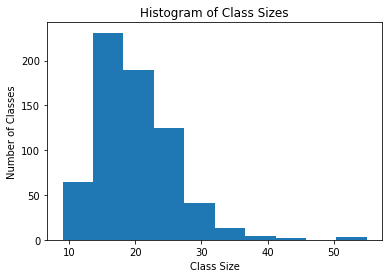

In [17]:
df_all = question1(df_grades)
# df_all = solution.question1()

ns = len(np.unique(df_all['student_id']))
nc = len(np.unique(df_all['class_id']))
nn = len(df_all)

print("{} students and {} classes".format(ns,nc))

df_all[["grade","class_id","student_id","major","firstname"]]

# Constructing the sparse regressor matrices

In a similar fashion to what we covered in the class we want to estimate a two-way fixed model of grates. Specifically, we are want to fit:

$$y_{ic} = \alpha_i + \psi_c + \epsilon_{ic}$$ 

where $i$ denotes each individual, $c$ denote each courses and $\epsilon_{ic}$ is an error term that will assume conditional mean independent of the assignment of students to courses.

We are going to estimate this using least-square. This requires that we construct the matrices that correspond to the equation for $y_{ic}$. We then want to consruct the $A$ and $J$ such that 

$$Y = A \alpha + J \psi + E$$ 

where for $n_s$ students each with $n_g$ grades in difference courses and a total of $n_c$ courses we have that $Y$ is $n_s \cdot n_g \times 1$ vector, $A$ is a $n_s \cdot n_g \times n_s$ matrix and $J$ is $n_s \cdot n_g \times n_c$. $\alpha$ is the vector of size $n_s$ and $\psi$ is a vector of size $n_c$.

Each fo the $n_s \cdot n_g$ correspond to a grade, in each row $A$ has a $1$ in the column corresponding to the individual of this row. Similary, $J$ has a $1$ for for the column corresponding to the class of that row.

So, I ask you to:

 1. construct these matrices using python sparse matrices `scipy.sparse.csc.csc_matrix`


<class 'scipy.sparse.csc.csc_matrix'>
(13464, 6515)
(13464, 673)
(13464,)
13464.0
13464.0


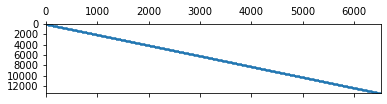

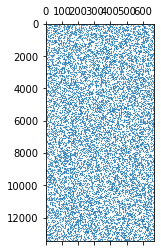

In [78]:
from scipy.sparse.linalg import spsolve
Y,A,J = solution.question2(df_all)

print(type(A))
print(A.shape)
print(J.shape)
print(Y.shape)
print(A.sum())
print(J.sum())

# getting a nice diagonal here requires sorting by the studend_id
plt.spy(A,aspect=0.1,markersize=0.2)
plt.show()
plt.spy(J,aspect=0.1,markersize=0.2)
plt.show()

# Estimating the model

Next we estimate our model using the OLS estiamtor formula. We first remove the last column of $J$ (since the model we wrote does not pin down a constant we force the last course to have $\psi=0$). Solve the linear system using the formula

$$ \hat{\gamma} = (M'M)^{-1} M' Y $$

where $M = [A,J]$ and $\gamma = (\alpha,\psi)$.

So do the following:

 1. select the last column simply by doing `J = J[:,1:(nc-1]]`
 2. use `scipy.sparse.hstack` to concatenate the matrices to create M
 3. use `scipy.sparse.linalg.spsolve` to solve a sparse linear system
 4. extract $\hat{\alpha}$ from $\hat{\gamma}$ by selecting the first $n_s$ terms 
 5. merge $\hat{\alpha}$ into `df_all`
 6. compute the variance of $\hat{\alpha}$ in `df_all`
 7. compute the variance of the residuals
 8. What share of the total variation in grades can be attributed to difference in students?


In [113]:
df_all, M, gamma_hat = solution.question3(df_all,A,J,Y)
print(df_all['alpha_hat'].var(),df_all['resid'].var(),df_all['grade'].var(),df_all['A'].var())
df_all[["grade","class_id","student_id","major","firstname","alpha_hat"]]

1.2723264013339926 0.2961433631652088 2.238309182130912 1.0014340821700642


,grade,class_id,student_id,major,firstname,alpha_hat
0,1.534625,AG1560,98443,ENGINEERING MECHANICS PHYSICS AND SCIENCE,Essie,1.641192
1,1.666892,FW3283,98443,ENGINEERING MECHANICS PHYSICS AND SCIENCE,Essie,1.641192
2,1.852535,JN5915,50321,BIOLOGICAL ENGINEERING,Marty,2.319451
3,1.957949,MO5833,50321,BIOLOGICAL ENGINEERING,Marty,2.319451
4,-1.616509,LM8058,62266,N/A (less than bachelor's degree),Renee,-0.955532
...,...,...,...,...,...,...
13459,-1.382056,IC2514,33549,ATMOSPHERIC SCIENCES AND METEOROLOGY,Charisse,-0.193704
13460,-0.251954,AA3460,4386,GENERAL MEDICAL AND HEALTH SERVICES,Riley,1.355011
13461,0.576073,ME7722,4386,GENERAL MEDICAL AND HEALTH SERVICES,Riley,1.355011
13462,-0.436195,BP6801,85286,PHYSICAL SCIENCES,Cyrus,0.140501


# A simple evaluation of our estimator

To see what we are dealing with, we are simly going to re-simulate using our estimated parameters, then re-run our estimation and compare the new results to the previous one. This is in the spirit of a bootstrap exercise, onyl we will just do it once this time.

Please do:

 1. create $Y_2 = M \hat{\gamma} + \hat{\sigma}_r E$ where $E$ is a vector of draw from a standard normal.
 2. estimate $\hat{\gamma}_2$ from $Y_2$
 3. report the new variance term and compare them to the previously estimated
 4. comment on the results (not that because of the seed and ordering, your number doesn't have to match mine exactly)


In [93]:
df_all = solution.question4(df_all,M,gamma_hat)
df_all['alpha_hat2'].var(),df_all['resid2'].var()

(1.4346423413900549, 0.13670786305558028)

Noticed how even the variance of the residual has shrunk? Now is the time to remember STATS 101. We have all heard this thing about degree of freedom correction! Indeed we should correct our raw variance estimates to control for the fact that we have estimated a bunhc of dummies. Usually we use $n/n-1$ because we only estimate one mean. Here however we have estimated $n_s +n_c - 1$ means! Hence we should use 

$$ \frac{N}{N-n_s -n_c +1} \hat{Var}(\hat{\epsilon}) $$

please do:

 1. compute this variance corrected for degree of freedom using your recomputed residuals 
 2. compare this variance to the variance you estimated in quetion 3
 3. what does this suggest?

In [121]:
solution.question4b(df_all)

Var2 with degree of freedom correction:0.29323477269082887


# Evaluate impact of academic measure on earnings 

In this section we load a separate data set that contains for each student their earnings at age 35. We are intereted in the effect of $\alpha$ on earnings. 

Do the following:

 1. load the data the earnings data listed in the intro
 2. merge $\alpha$ into the data
 3. regress earnings on $\alpha$.

In [108]:
df_earnings = solution.question5(df_all)
df_earnings

                            OLS Regression Results                            
Dep. Variable:               earnings   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     183.2
Date:                Fri, 29 May 2020   Prob (F-statistic):           3.27e-41
Time:                        16:24:02   Log-Likelihood:                -9566.5
No. Observations:                6732   AIC:                         1.914e+04
Df Residuals:                    6730   BIC:                         1.915e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1072      0.015     -7.388      0.0

,student_id,major,firstname,earnings,alpha_hat
0,98443,ENGINEERING MECHANICS PHYSICS AND SCIENCE,Essie,0.345659,1.641192
1,50321,BIOLOGICAL ENGINEERING,Marty,-0.911299,2.319451
2,62266,N/A (less than bachelor's degree),Renee,-2.666607,-0.955532
3,50732,MUSIC,Franklin,-0.416194,2.119203
4,95557,ECONOMICS,Antonio,0.775642,2.736958
...,...,...,...,...,...
6727,60663,ECOLOGY,Curley,-1.137731,0.966792
6728,88662,HEALTH AND MEDICAL PREPARATORY PROGRAMS,Arvil,-2.481996,0.063130
6729,33549,ATMOSPHERIC SCIENCES AND METEOROLOGY,Charisse,-0.670838,-0.193704
6730,4386,GENERAL MEDICAL AND HEALTH SERVICES,Riley,2.373190,1.355011


# Bias correction - construct the Q matrix

We want to apply bias correction to refine our results. As we have seen in class thaqt we can directly compute the bias of the expression of interest.

$$ E[ \hat{\gamma} Q \hat{\gamma}' ] = \gamma Q \gamma + \frac{\sigma^2}{n} \text{Tr}[ ( M'M )^{-1} Q] $$

under homoskedatic assumption of the error and hence we get the following expresison for the bias for any $Q$ matrix:

$$ B = \frac{\sigma^2}{N} \text{Tr}[ ( M'M )^{-1} Q] $$

When computing the variance of the measured ability of the student, we simply use a diagonal matrix on $\gamma$ which selects only the ability part and removes the average. In other words we want to construct:

do:
 1. Construct such Q matrix.
 2. check that $\gamma Q \gamma' = \hat{Var}(\hat{a})$.

In [117]:
# a small example if we had ns=5,nc=4
Qbis = solution.question6(ns=5,nc=4)
print(Qbis)

# the full Q
Q = solution.question6(ns,nc)

# comparing Q expression to df_all expression
1/(ns)*np.matmul( gamma_hat, np.matmul(Q,gamma_hat )), gamma_hat[range(ns)].var()

[[ 0.8 -0.2 -0.2 -0.2 -0.2  0.   0.   0. ]
 [-0.2  0.8 -0.2 -0.2 -0.2  0.   0.   0. ]
 [-0.2 -0.2  0.8 -0.2 -0.2  0.   0.   0. ]
 [-0.2 -0.2 -0.2  0.8 -0.2  0.   0.   0. ]
 [-0.2 -0.2 -0.2 -0.2  0.8  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0. ]]


(1.2933390582972624, 1.293339058297262)

# Bias correction - Variance sahre

We are now finally in the position to compute our bias. We have are matrix $Q$. Now we also need the variance of the residual! Given what we have learn in Question 4, we definitely want to use the formula with degree of freedom correction.

1. Compute $\sigma^2_r$ with the degree of freedom correction
2. Invert $M'M$ using `scipy.sparse.linalg`
3. Compute $B = \frac{\sigma^2}{N} \text{Tr}[ ( M'M )^{-1} Q]$ using `np.trace`
4. Remove this from original estimate to get the share of variance explained by student differences!

Note that inversing a matrix is far longer than solving a linear system. You might need to be patient here!


In [124]:
B = solution.question7(M,Q,df_all)
B

/Users/thibautlamadon/anaconda3/envs/econ21340-env/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:310: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/thibautlamadon/anaconda3/envs/econ21340-env/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:208: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


0.34566337103526645

In [125]:
gamma_hat[range(ns)].var() - B

0.9476756872619955

# Bias correction - Regression coefficient

Finally, we look back at our regression of earnings on estimated academic ability. We have seen in class that when the regressor has measurment error this will suffer from attenuation bias. Here we now know exactly how much of the variance is noise thanks to our bias correction.

The attenuation bias is given by :

$$ \beta_2 = \frac{Var(x)}{Var(x) + B} \beta $$

We then decide to compute a correction for our regression using our estimated $B$. 

Do:

 1. compute the corrected beta
 2. FIY, the true $\beta$ I used to simulate the data was **2.0**, is your final parameter far? Is is economically different from the $\beta$ we got in Question 5?
 



# Conclusion

I hope you have learned about the pitfalls of over-fitting in this assignment! There are many and they can drastically affect the results and the conclusion of an empirical analysis. 

This is the end of the class, I hope you enjoyed it and that you learned a thing or twom, have a nice summer!